# RENT applied to a binary classification problem

This Jupyter notebook illustrates how to apply RENT to your data for feature selection with a *binary classification* problem. It is also complimentary to the manscript published at arXiv.org.

[RENT -- Repeated Elastic Net Technique for Feature Selection](https://arxiv.org/abs/2009.12780)

For an example on how to use RENT for feature selection on a **regression problem**, please have a look this [Jupyter Notebook](https://github.com/NMBU-Data-Science/RENT/blob/master/src/RENT/Regression_example.ipynb).

## Content

1. [Load Wisconsin Breast Cancer dataset](#Load-Wisconsin-Breast-Cancer-dataset)
2. [Define RENT ensemble for binary classification](#Define-RENT-ensemble-for-binary-classification)
3. [Train RENT ensembles and inspect results](#Train-RENT-ensembles-and-inspect-results)
4. [Set selection criteria cutoffs](#Set-selection-criteria-cutoffs)
5. [Investigation of class predictions](#Investigation-of-class-predictions)
6. [Check performance using only selected features](#Check-performance-using-only-selected-features)
7. [Feasibility study regarding the features selected by RENT](#Feasibility-study-regarding-the-features-selected-by-RENT)

---

First import needed modulse and apply some settings to the Jupyter notebook for better visualisation of results.

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 2000)
import RENT

import warnings
warnings.filterwarnings("ignore")

### Load Wisconsin Breast Cancer dataset

Now load the data from sciki-learn, store it in a pandas DataFrame and split it into a training and test set.

In [2]:
from sklearn.datasets import load_breast_cancer
wisconsin = load_breast_cancer()
data = pd.DataFrame(wisconsin.data)
data.columns = wisconsin.feature_names
target = wisconsin.target

In [3]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, target, random_state=0, shuffle=True)

In [4]:
train_data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
293,11.85,17.46,75.54,432.7,0.08372,0.05642,0.026880,0.022800,0.1875,0.05715,0.2070,1.2380,1.234,13.88,0.007595,0.015000,0.014120,0.008578,0.01792,0.001784,13.06,25.75,84.35,517.8,0.1369,0.17580,0.13160,0.09140,0.3101,0.07007
332,11.22,19.86,71.94,387.3,0.10540,0.06779,0.005006,0.007583,0.1940,0.06028,0.2976,1.9660,1.959,19.62,0.012890,0.011040,0.003297,0.004967,0.04243,0.001963,11.98,25.78,76.91,436.1,0.1424,0.09669,0.01335,0.02022,0.3292,0.06522
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.144000,0.097910,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.024230,0.039500,0.016780,0.01898,0.002498,23.69,38.25,155.00,1731.0,0.1166,0.19220,0.32150,0.16280,0.2572,0.06637
278,13.59,17.84,86.24,572.3,0.07948,0.04052,0.019970,0.012380,0.1573,0.05520,0.2580,1.1660,1.683,22.22,0.003741,0.005274,0.010650,0.005044,0.01344,0.001126,15.50,26.10,98.91,739.1,0.1050,0.07622,0.10600,0.05185,0.2335,0.06263
489,16.69,20.20,107.10,857.6,0.07497,0.07112,0.036490,0.023070,0.1846,0.05325,0.2473,0.5679,1.775,22.95,0.002667,0.014460,0.014230,0.005297,0.01961,0.001700,19.18,26.56,127.30,1084.0,0.1009,0.29200,0.24770,0.08737,0.4677,0.07623


### Define RENT ensemble for binary classification

**The main idea**

Using the RENT approach we will train an **ensemble of unique models** based on **unique subsets** of the training data. Since each model is trained on a unique subset, all models will be slightly different from each other and elastic net regularisation **may select different features for each model**. 

RENT investigates **how consistenly elastic net selects features** across all unique models by analysing distributions of the weight sizes of each feature. Using specific selection criteria $\tau_1$, $\tau_2$ and $\tau_3$ applied to those weight size distributions, we can regulate how aggressively RENT will select features from the full set of features. For more details, please consult the paper mentioned at the top of this Juptyer notebook

**Elastic net regularisation**

$\lambda_{enet}(\beta) = \gamma [\alpha\lambda_1(\beta)+ (1-\alpha)\lambda_2(\beta)]$

Since the average prediction performance of the ensemble may vary for different combinations of $\gamma$ and $\alpha$ we pre-define a number of values for each and store them in lists `my_C_params` and `my_l1_ratios` and train RENT ensembles for each pair-wise combination.

**Note** regarding elastic net regularisation term above we follow the scikit-learn convention:

* RENT input paramter `C` represents inverse values of $\gamma$
* RENT input parameter `l1_ratio` represents values of $\alpha$ for the mix of L1 and L2 regularisation. `l1_ratio = 1` is equivalent to using L1-regularisation, while `l1_ratio = 0` is equivalent to using L2-regularisation 

In the code below we initialise the `RENT_Classification` ensemble. In addition to `C` and `l1_ratio` we can define:

* `parameter_selection`: more on this below in section [insert when done]
* `poly`: whether to include polynominals and interactions of features. Should be beneficial if data are non-linear, but computational cost may increase very much. 
* `testsize_range`: this allows for more randomness in models by allowing test set sizes to vary within range defined in tuple (lower end, higher end). Set both parameters to the same value to secure identical test set size.
* `scoring`: performance metric to use for model evaluation
* `method`: which classification algorithm to choose for model training. Uses logistic regression by default.
* `K`: how many models the ensemble should consist of. The higher the better, but computationally more expensive.
* `verbose`: how much to show during training process

For more detailed information for each input parameter, please consult the documentation [link here]

In [5]:
# Define a range of regularisation parameters C for elastic net. A minimum of at least one value is required.
my_C_params = [0.1, 1, 10]

# Define a reange of l1-ratios for elastic net.  A minimum of at least one value is required.
my_l1_ratios = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

# Define setting for RENT
analysis = RENT.RENT_Classification(data=train_data, 
                                    target=train_labels, 
                                    feat_names=train_data.columns, 
                                    C=my_C_params, 
                                    l1_ratios=my_l1_ratios,
                                    parameter_selection=False,
                                    poly='OFF',
                                    testsize_range=(0.25,0.25),
                                    scoring='mcc',
                                    method='logreg',
                                    K=100,
                                    verbose=0)

data dimension: (426, 30)  data type: <class 'pandas.core.frame.DataFrame'>
target dimension (426,)
regularization parameters C: [0.1, 1, 10]
elastic net l1_ratios: [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
number of models in ensemble: 100
classification method: logreg
verbose: 0


### Train RENT ensembles and inspect results

Now train all RENT ensembles, i.e. one RENT ensemble for each pair-wise combination of `C` and `l1_ratio`. With three values for `C` and seven values for `l1_ratio` a total of $3*7=21$ RENT ensembles are computed. This is computationally expensive and may take some time. For this example it took just below 5 minutes on a [Lenovo T470](https://www.lenovo.com/us/en/laptops/thinkpad/thinkpad-t-series/ThinkPad-T470/p/22TP2TT4700).

In [6]:
analysis.train()

If it is of interest, one can extract time for computation of all ensembles.

In [21]:
analysis.get_runtime()

'268.206s'

We can inspect now results from the RENT ensembles we have computed. Important questions are:

1. What are the prediction performances for each combination of `C` and `l1_ratio`?
2. Which combination of `C` and `l1_ratio` selects the lowest number of features?
3. Which combination of `C` and `l1_ratio` achieves the best balance of above point 1 and 2? That is, keep as few features as possible, but keep prediction performance at a high level.

The `.get_enetParam_matrices()` method returns three data frames that provide information on point 1, 2 and 3 respectively. 

1. `scores` (performances)
2. `zeroes` (percentage of features excluded (not selected) relative to the total number of features)
3. `harmonic_mean` (describe here)

In [8]:
scores, zeroes, harmonic_mean = analysis.get_enetParam_matrices()

From the `scores` dataframe we see that Matthews correlation coefficient (the metric we chose when we initialised the RENT ensemble) varies roughly between 0.920 and 0.956 for the different combinations of `C` and `l1_ratio`. The columns represent different values of `C` while the rows represent different values of `l1_ratio`. So the best performance 0.955071 is achieved for `C = 1.0` and `l1_ratio = 0.25`. But does it how many feature weights are set to zero with every `C` and `l1_ratio` combination? We can read this information from the data frame named `zeroes`.

In [16]:
pd.DataFrame(scores)

Scores,0.1,1.0,10.0
0.00,0.945064,0.954386,0.940014
0.10,0.943091,0.954420,0.939825
0.25,0.940361,0.955071,0.939237
0.50,0.932889,0.954062,0.938083
0.75,0.922392,0.950480,0.936551
0.90,0.919603,0.944903,0.933159
1.00,0.920026,0.943071,0.930981


Let's view the percentage of feature weights set to zero by the elastic net. As expected L2 regularisation (`l1_ratio = 0`) sets no weights to zero, while L1 regularisation (`l1_ratio = 1`) most to zero. Not unexpectedly, the strongest regularisation with `C = 0.1` and `l1_ratio = 1` sets most of the feature weights to zero, i.e. close to 79% (0.788667). But the performance in the `scores` data frame above for this combination is among the lowest. So which combination should we choose that balances best high performance and high number of feature weights set to zero?

In [10]:
zeroes

Zeroes,0.1,1.0,10.0
0.00,0,0,0
0.10,0.071,0.0316667,0.004
0.25,0.203,0.0956667,0.0273333
0.50,0.403667,0.215,0.062
0.75,0.561667,0.345333,0.106667
0.90,0.714667,0.442333,0.141667
1.00,0.788667,0.529667,0.164667


The `harmonic_mean` data frame helps us to make this decision. The combination of `C = 1` and `l1_ratio = 1` results in 0.333296, the highest value in `harmonic_mean`. For this combination the performance is 0.943071 while it gets rid of just under 53% of the features.

In [11]:
harmonic_mean

Harmonic Mean,0.1,1.0,10.0
0.00,0.000000,0.000000,0.000000
0.10,0.079252,0.038574,0.005027
0.25,0.178773,0.108179,0.032616
0.50,0.216294,0.212880,0.068307
0.75,0.070817,0.291338,0.105413
0.90,0.000000,0.313986,0.122197
1.00,0.011789,0.333296,0.126476


We can ask RENT to provide this combination automatically using `.get_enet_params()`.

In [12]:
# can play around with enet parameter setting...
analysis.get_enet_params()

(1.0, 1.0)

If we should prefer another combination, we can set it manually calling `.set_enet_params(C, l1_ratio)` with the desired values. 

In [30]:
analysis.set_enet_params(0.1, 0.1)

In [31]:
analysis.get_enet_params()

(0.1, 0.1)

Let's set it back to the suggested combination.

In [32]:
analysis.set_enet_params(1, 1)

### Set selection criteria cutoffs

Here we can set how agressively we want RENT to select features. 

Below we set `tau_1 = 0.9`, meaning that we will consider only features that were selected in 90% or more across the ensemble models. 

Sometimes features are selected by elastic net (weight is non-zero), but they might be very small. This happens more often when `l1_ratio` is such that the L2-part of the regularisation gets more influence than L1 (smaller `l1_ratio`). In addition to that some weights of a feature as consistently small very small across all models, they may be positive or negative. This may indicate that even though such a feature is selected, it may not be very meaningful, since its feature weights are small and often have different signs. The `tau_2` criterion simply allows the user to define a required minimum proportion of the parameter estimates to have the same sign.

`tau_3` is chosen such that it corresponds to the well-known statistical Student’s t-test with rejection of the null hypothesis assuming that the mean of the feature weights across all models is equal to zero. In other words, we test whether the feature weighs are consistently high with low variance across the K models.

Only if the resulting values are higher for all three criteria, the RENT will selecte the feature.

In [14]:
selected_features = analysis.selectFeatures(tau_1=0.9, tau_2=0.9, tau_3=0.975)

Now let's have a look at the summary for `tau_1`, `tau_2` and `tau_3` across all features using `.summary_criteria()`. We can see for example that RENT selects feature `radius error`, since its vaues for `tau_1`, `tau_2` and `tau_3` are all higher than the cutoffs set in the code above. Feature `mean concave points` gets close, but cutoffs for `tau_1` and `tau_2`are not satisfied. If we would set lower cutoffs, say `tau_1=0.8` and `tau_2=0.8` it would be selected. By varying cutoffs for `tau_1`, `tau_2` and `tau_3` we can define how strict RENT has to be when selecting features.

In [18]:
analysis.summary_criteria()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
tau_1,0.050000,0.71,0.020000,0.010000,0.130000,0.0,0.160000,0.88,0.87,0.060000,0.99,0.14000,0.210000,0.090000,0.090000,0.93,0.020000,0.010000,0.090000,0.91,0.99,1.0,0.95,0.68,0.81,0.010000,1.0,0.99,0.94,0.37
tau_2,0.050000,0.71,0.020000,0.010000,0.130000,0.0,0.160000,0.88,0.87,0.060000,0.99,0.10000,0.210000,0.090000,0.030000,0.93,0.020000,0.010000,0.090000,0.91,0.99,1.0,0.95,0.68,0.81,0.010000,1.0,0.99,0.94,0.37
tau_3,0.987411,1.00,0.919081,0.841336,0.997907,NaN,0.999692,1.00,1.00,0.974571,1.00,0.99758,0.999867,0.992514,0.549326,1.00,0.855056,0.841336,0.994162,1.00,1.00,1.0,1.00,1.00,1.00,0.841336,1.0,1.00,1.00,1.00


Let's check which features were selected based on the cutoffs we defined above.

In [15]:
selected_features

array([10, 15, 19, 20, 21, 22, 26, 27, 28], dtype=int64)

Using the indices of the selected features we can identify the feature names.

In [34]:
train_data.columns[selected_features]

Index(['radius error', 'compactness error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst concavity',
       'worst concave points', 'worst symmetry'],
      dtype='object')

To get a better impression on how often a feature weight was non-zero across all models, we use `.plot_selection_frequency()`. We can see from the plot that across all models in the ensemble elastic net selected never selected feature at index 5, i.e. elastic net always set the weights for that feature to zero. Elatic net selected some features for a few models in the ensemble, but typically around 20% of the time (<0.2 on the vertical axis) or lower (for example features at index 0, 2-6, etc). This indicates that the selection of these samples by elastic net is very dependent on the subset of the training samples. 

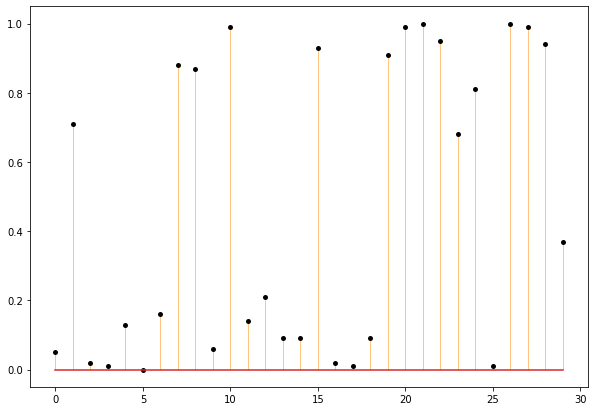

In [17]:
analysis.plot_selection_frequency()

One has to keep in mind though, that a feature may be selected by elastic net (i.e. the weight i non-zero), but i may be:

1. very small and hence not very influential to the model (even though it was selected by elastic net)
2. alternating its sign (positive or negative), which also indicates unstable importance of this feature.

To get more detailed information on the weight sizes one could investigate the full distribution of the weights of each feature across all models. This is possible by calling `.get_weight_distributions()`. This returns an array holding all weights across all models in the ensemble (rows) and each feature (columns). Here we can see that for the feature at index 5 (column named 5) the weights are always 0 across all 100 models applied in this example (corresponding to the plot above). 

In [19]:
analysis.get_weight_distributions()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.000000,-0.180906,0.000000,0.000000,0.000000,0.0,0.000000,-0.883606,-0.341210,0.000000,-2.757998,0.000000,0.000000,0.000000,0.000000,0.970869,0.000000,0.000000,0.000000,0.401802,-1.544815,-1.139333,-0.191462,-1.426375,0.000000,0.000000,-0.907366,-1.649573,-0.351823,0.000000
1,0.000000,-0.035142,0.000000,0.000000,0.000000,0.0,0.000000,-0.518945,-0.054613,0.000000,-3.236148,0.000000,0.000000,0.000000,0.000000,0.394078,0.000000,0.000000,0.000000,0.649877,-1.842251,-1.008839,-0.758810,0.000000,-0.224232,0.000000,-0.987837,-1.812394,-0.752890,0.000000
2,0.000000,-0.425537,0.000000,0.000000,0.000000,0.0,0.000000,-0.554596,-0.331965,0.000000,-2.277119,0.205607,0.000000,0.000000,0.000000,0.611755,0.000000,0.000000,0.000000,0.355751,-2.019687,-1.287755,-0.823300,-1.018212,-0.304069,0.000000,-0.678409,-1.482806,-0.517475,0.000000
3,0.000000,-0.461786,0.000000,0.000000,0.000000,0.0,-0.331684,-0.114580,-0.083983,0.000000,-2.239332,0.000000,0.000000,0.000000,0.000000,0.785094,0.000000,0.000000,0.000000,0.183510,-2.551994,-0.847061,-1.492273,-0.738307,-0.413277,0.000000,-0.404757,-1.761026,-0.409352,0.000000
4,0.000000,-0.353075,0.000000,0.000000,-0.100960,0.0,0.000000,0.000000,-0.058121,0.000000,-2.566050,0.000000,0.000000,0.000000,0.000000,0.667817,0.000000,0.000000,0.000000,0.295916,-1.588574,-1.011287,-1.881435,0.000000,-0.065233,0.000000,-0.744542,-2.172367,-0.441437,-0.018125
5,0.000000,-0.140316,0.000000,0.000000,0.000000,0.0,0.000000,-0.810477,-0.300844,0.000000,-3.053780,0.000000,0.000000,0.000000,0.000000,0.323848,0.000000,0.000000,0.000000,0.785021,-1.360349,-1.148741,-0.978110,-1.017752,-0.101136,0.000000,-0.236852,-2.202400,-0.628460,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.900720,-0.121461,-0.218951,0.064320,-2.490583,0.000000,-0.599865,0.000000,0.000000,0.805773,0.000000,0.000000,0.000000,0.486582,-0.797444,-1.265634,-1.259663,-0.474317,-0.609201,0.000000,-0.310286,-1.908156,-0.290731,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.435962,0.039058,-0.353422,0.000000,0.000000,-0.556497,0.000000,0.103275,0.000000,0.000000,0.000000,0.085531,-2.730135,-1.588115,0.000000,-2.816349,-0.861442,0.000000,-0.489559,-1.521093,-0.521476,0.000000
8,0.000000,-0.462966,0.000000,0.000000,0.000000,0.0,0.000000,-1.281557,-0.185346,0.000000,-2.461366,0.000000,-0.202839,0.000000,0.000000,1.094131,0.000000,0.000000,0.000000,0.226214,-1.514544,-0.807842,-1.438883,-0.176758,-0.064953,0.000000,-0.972477,-1.193923,-0.486892,-0.207613
9,0.000000,-0.006528,0.000000,0.000000,0.000000,0.0,0.000000,-0.367208,-0.408313,0.000000,-2.643861,0.000000,0.000000,0.000000,0.000000,0.850659,0.000000,0.000000,0.000000,0.436978,-0.958477,-1.317072,-0.601001,-1.441171,-0.081440,0.000000,-0.856769,-2.081255,-0.466760,0.000000


### Investigation of class predictions

Since we use an ensemble of models, we can make predict the class of the validations samples during the RENT process. We can get more details by calling `.summery_objects()` which will return a data frame holding all predictions.

In the example below we can see that patient 489 was 25 times (out of K=100 models in the ensemble) in the validation set (column `# test`). That means we can get 25 predictions from 25 unique models and investigate how well predictions worked for this patient. Patient 489 belongs to class 0 (column `class`) and was predictied incorrectly 12 times (column `# incorrect`) out of 25 predictions, which results in 48% incorrect classifications (column `% incorrect`). 

Looking at this dataframe we can see that most of the patients were predicted correctly every time, however, there are some patients that were predicted incorrectly every time (patients 135, 81, 297, 73, 40). It might be worth investigating why it is so difficult predict the correct class for these patients by comparing them to patients from the same class that are predicted correctly most or all of the times.   

In [20]:
analysis.summary_objects()

,# test,class,# incorrect,% incorrect
293,27,1,0,0.000000
332,23,1,0,0.000000
565,20,0,0,0.000000
278,22,1,0,0.000000
489,25,0,12,48.000000
346,25,1,0,0.000000
357,30,1,0,0.000000
355,28,1,0,0.000000
112,24,1,0,0.000000
68,26,1,4,15.384615


In [22]:
analysis.get_object_probabilities()

,K(1),K(2),K(3),K(4),K(5),K(6),K(7),K(8),K(9),K(10),K(11),K(12),K(13),K(14),K(15),K(16),K(17),K(18),K(19),K(20),K(21),K(22),K(23),K(24),K(25),K(26),K(27),K(28),K(29),K(30),K(31),K(32),K(33),K(34),K(35),K(36),K(37),K(38),K(39),K(40),K(41),K(42),K(43),K(44),K(45),K(46),K(47),K(48),K(49),K(50),K(51),K(52),K(53),K(54),K(55),K(56),K(57),K(58),K(59),K(60),K(61),K(62),K(63),K(64),K(65),K(66),K(67),K(68),K(69),K(70),K(71),K(72),K(73),K(74),K(75),K(76),K(77),K(78),K(79),K(80),K(81),K(82),K(83),K(84),K(85),K(86),K(87),K(88),K(89),K(90),K(91),K(92),K(93),K(94),K(95),K(96),K(97),K(98),K(99),K(100)
293,NaN,9.904896e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.939854e-01,9.944382e-01,NaN,NaN,NaN,9.960704e-01,NaN,NaN,NaN,NaN,NaN,9.937263e-01,9.922473e-01,NaN,NaN,9.906086e-01,9.940649e-01,9.946012e-01,NaN,NaN,NaN,9.963873e-01,NaN,NaN,NaN,NaN,NaN,NaN,9.916154e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.928916e-01,NaN,NaN,9.917027e-01,NaN,NaN,NaN,NaN,9.931229e-01,NaN,NaN,9.945827e-01,NaN,NaN,NaN,9.940945e-01,9.928989e-01,NaN,NaN,NaN,NaN,NaN,NaN,9.921140e-01,NaN,NaN,NaN,9.977818e-01,9.954555e-01,NaN,NaN,9.911781e-01,NaN,NaN,9.948750e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.923352e-01,NaN,9.942030e-01,9.982000e-01,NaN,NaN,NaN,NaN,9.958518e-01,NaN,9.938736e-01
332,NaN,NaN,NaN,NaN,NaN,9.990910e-01,NaN,9.992680e-01,9.990359e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.986813e-01,9.986761e-01,NaN,9.992878e-01,9.995390e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.988214e-01,NaN,NaN,9.995329e-01,NaN,9.989461e-01,9.989708e-01,NaN,NaN,NaN,NaN,NaN,NaN,9.989789e-01,NaN,NaN,NaN,NaN,NaN,NaN,9.992920e-01,NaN,9.983177e-01,NaN,NaN,9.991112e-01,NaN,9.987533e-01,NaN,9.992093e-01,NaN,NaN,NaN,NaN,NaN,9.992495e-01,9.994019e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.982862e-01,9.995927e-01,NaN,9.993225e-01,NaN,NaN,NaN,NaN,NaN,NaN,9.994254e-01
565,NaN,6.421978e-06,NaN,1.050972e-06,2.332093e-06,1.497645e-06,NaN,3.852756e-06,NaN,2.411954e-06,1.976325e-06,NaN,NaN,NaN,1.648916e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.048696e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.389947e-07,NaN,1.304963e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.876236e-06,NaN,NaN,NaN,1.885239e-06,1.923457e-06,1.145839e-06,NaN,NaN,NaN,NaN,NaN,NaN,3.685845e-06,NaN,NaN,NaN,4.447484e-06,NaN,NaN,NaN,NaN,NaN,NaN,2.352360e-06,2.221168e-06,NaN,NaN,NaN,NaN,NaN,NaN,6.757924e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278,NaN,NaN,NaN,9.894689e-01,9.896302e-01,NaN,9.940158e-01,NaN,NaN,NaN,9.914271e-01,NaN,NaN,NaN,NaN,NaN,NaN,9.892122e-01,NaN,NaN,NaN,9.870869e-01,NaN,NaN,9.855071e-01,NaN,9.844073e-01,NaN,NaN,NaN,NaN,9.929197e-01,NaN,9.916921e-01,NaN,NaN,NaN,NaN,9.884872e-01,NaN,NaN,9.877615e-01,9.925112e-01,NaN,NaN,NaN,NaN,NaN,NaN,9.910918e-01,NaN,9.806576e-01,NaN,9.917626e-01,NaN,NaN,NaN,NaN,NaN,NaN,9.924250e-01,NaN,9.936498e-01,9.937996e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.926103e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.908798e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.907783e-01,NaN,NaN,NaN,NaN,NaN
489,3.539825e-01,NaN,NaN,NaN,NaN,NaN,7.572532e-01,1.635112e-01,NaN,NaN,NaN,NaN,NaN,4.596874e-01,2.422430e-01,6.280383e-01,NaN,NaN,NaN,NaN,NaN,NaN,4.995157e-01,NaN,NaN,5.614830e-01,NaN,NaN,5.500224e-01,4.403722e-01,NaN,6.643173e-01,NaN,NaN,NaN,1.602354e-01,1.635696e-01,NaN,NaN,NaN,NaN,NaN,8.703905e-01,NaN,NaN,3.110799e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.111293e-01,NaN,NaN,NaN,1.220836e-01,NaN,NaN,NaN,NaN,NaN,NaN,5.528547e-01,NaN,NaN,5.068204e-01,NaN,NaN,5.998627e-01,NaN,NaN,NaN,NaN,NaN,6.146509e-01,NaN,4.013063e-01,6.555563e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.914268e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.010049e-01
346,NaN,NaN,NaN,9.973830e-01,NaN,9.983723e-01,NaN,NaN,NaN,9.972414e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.978533e-01,NaN,NaN,9.974949e-01,9.984644e-01,NaN,NaN,NaN,NaN,9.985415e-01,9.981356e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.983127e-01,NaN,NaN,9.965614e-01,NaN,NaN,NaN,NaN,9.978067e-01,NaN,9.959700e-0

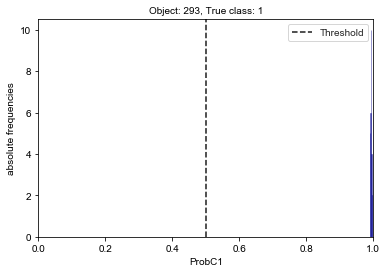

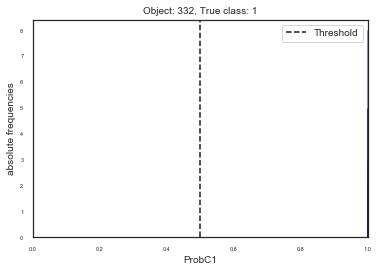

In [23]:
analysis.plot_object_probabilities(object_id=[293, 332])

loo


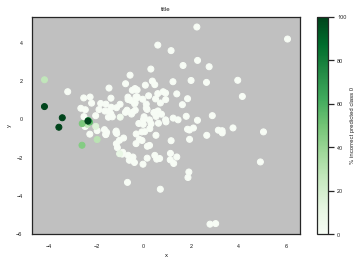

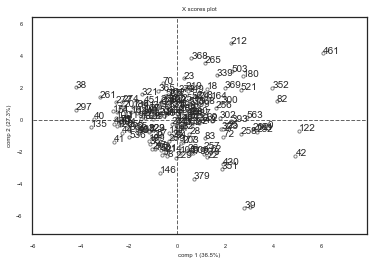

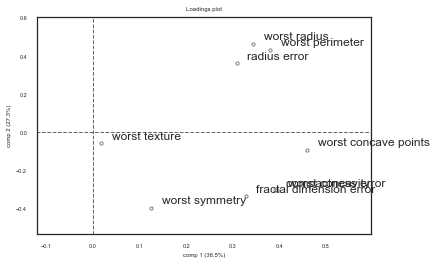

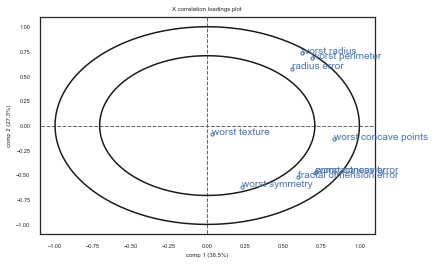

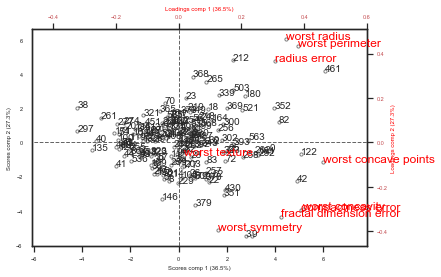

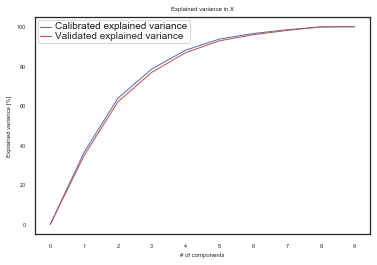

In [24]:
analysis.plot_object_PCA(group=0)

loo


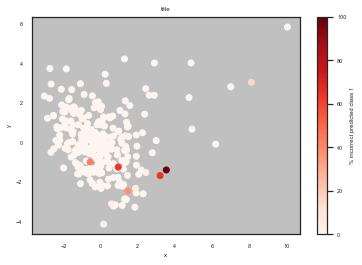

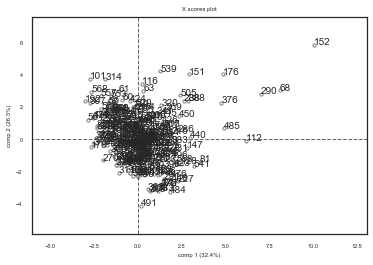

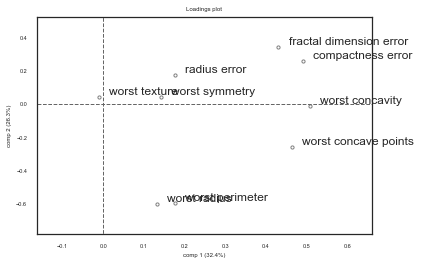

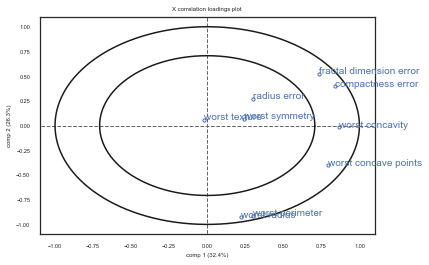

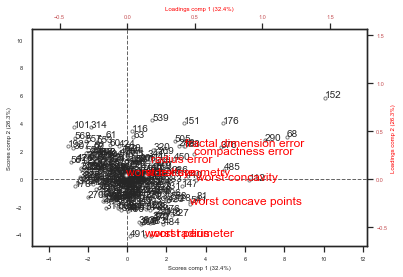

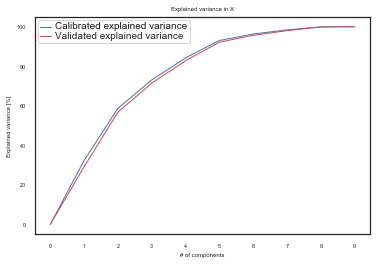

In [25]:
analysis.plot_object_PCA(group=1)

loo


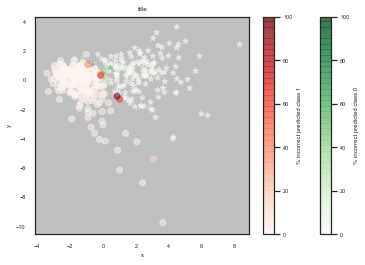

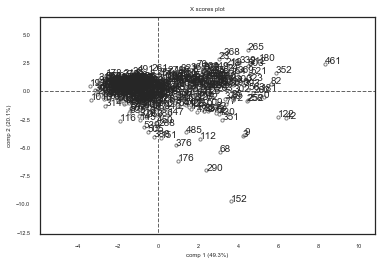

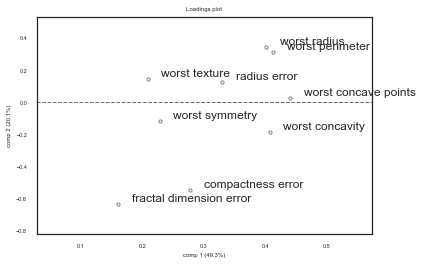

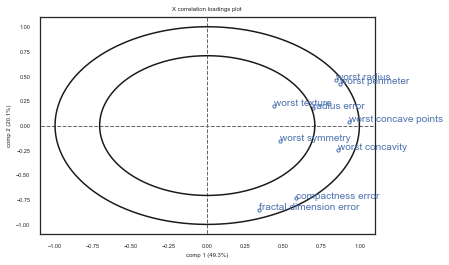

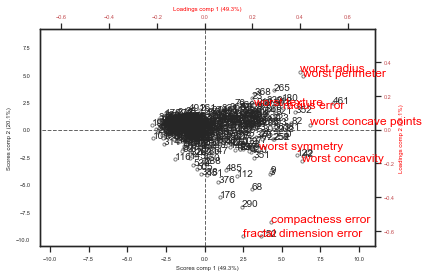

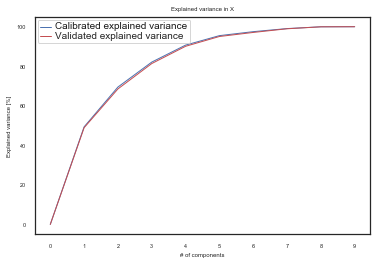

In [26]:
analysis.plot_object_PCA(group='both')

### Check performance using only selected features

RENT selected some features based on the distribution of the weights of each feature across the ensenmble of models. Now let's check how well a model performs that uses only the selected features on unseen data, i.e data that has not been touched by the RENT method. 

In [29]:
#predict test data

# Import what is needed for prediction and evaluation of predictions from test set
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as LR

# Scale the data accordingly
sc = StandardScaler()
train_data_1 = sc.fit_transform(train_data.iloc[:, selected_features])
test_data_1 = sc.transform(test_data.iloc[:, selected_features])

# Train model with 
model = LR(penalty='none', max_iter=8000, solver="saga", random_state=0).\
        fit(train_data_1, train_labels)

# Print results
print("f1 1: ", f1_score(test_labels, model.predict(test_data_1)))
print("f1 0: ", f1_score(1 - test_labels, 1 - model.predict(test_data_1)))
print("Accuracy: ", accuracy_score(test_labels, model.predict(test_data_1)))
print("Matthews correlation coefficient: ", matthews_corrcoef(test_labels, model.predict(test_data_1)))


f1 1:  0.9491525423728815
f1 0:  0.9174311926605505
Accuracy:  0.9370629370629371
Matthews correlation coefficient:  0.8675034270773535


### Feasibility study regarding the features selected by RENT

In order to validate the selected features we benefit to know whether the selected features provide models that perform better than random. This can be done in two complimentary ways:

1. randomly draw the same number of features from the full set of features and compute model performance. Do this many times and collect model performances. Compute average performance across these models and check how many of those are higher than the performance of the selected features. One should expect that the average performance of the models with randomly drawn features would be substantially lower than the performance of the model with the selected features. One should also expect that the number of performances with randomly drawn features higher than the performance of the model with the selected features should be quite low. Say, if 4 out of 100 models with randomly drawn features are higher than the performance with the selected features, this would result in a p-value 4 / 100 = 0.04. It is up to the user where to set the required significance level.

2. permute the lables of the data and compute model performance using the selected features every time. In the same manner as in point 1 above, collect the performances based on permuted labels and compute average performance. One should expect that the average performance for the models with permuted labels should be substantially lower. Also as in 1. one can compute the p-value from the permutation based model performances by checking how many of the models provided higher performance than the model using the original lables without permutation.

A nice source on these permuation based p-values is provideded [here](https://www.jwilber.me/permutationtest/ )

In [27]:
analysis.feasibility_study(test_data, test_labels, K_feas=100)

Average score random feature drawing:  0.8834450059211635
Average score permutation of test labels:  0.008743488630155534
